In [164]:
#Enter Key here: B2@2024KAUSTUKICv9YZDN


# Exercise: Image Denoising

## Dataset Description:
- You have been given 2500 images of... cats.
- Someone has blurred some of them!
- You have train a model to unblur the images
- The train dataset only has clean images
- The test data set are the ones blurred by the intruder

## Objective:
You are tasked with implementing a U-Net architecture for image denoising/deblurring.




# Tasks:

## Preprocessing:
- Define transformations: Resize images to 64x64 pixels and convert them to tensors.
- Define your data loaders.

## U-Net Model Development:

- You are restricted to only developing a U-Net architecture.
- Ensure having skip connections.

## Training:

- Compile and train your model using the training dataset.
- You can use the blurbatch function provided below to get the blurred images on the training batches
- Choose an appropriate loss function and optimizer.
- Plot a visual representation of the decreasing loss over the training period.

## Evaluation:

Create a 2x5 figure to visually assess the model's performance. Display four distorted images alongside their corresponding denoised counterparts generated by your trained U-Net model. Here is an example:

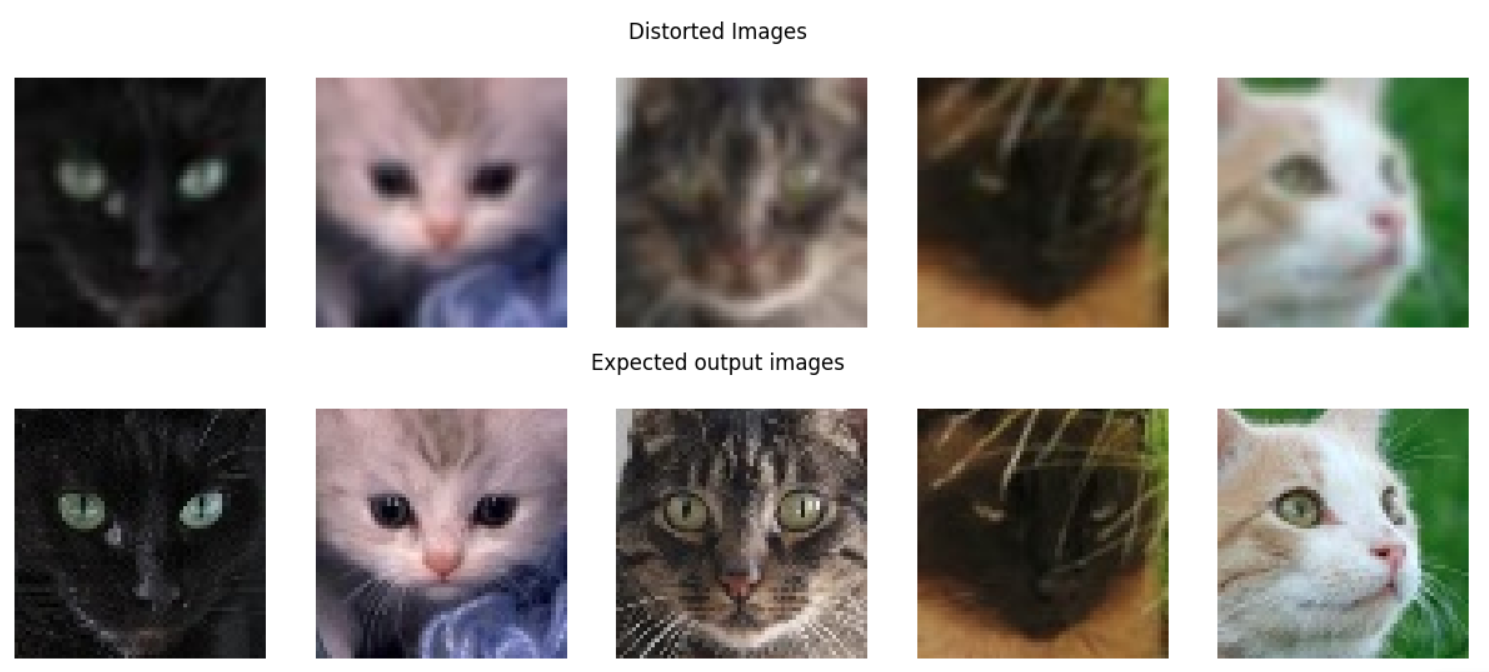

In [165]:
# Import necessary libraries
import os
import gdown
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torchvision.utils
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from IPython.display import clear_output
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
from torchvision import models,transforms
from torchvision.utils import make_grid
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import imageio as imo
import os
import time
from sklearn.metrics import classification_report
from PIL import Image

In [166]:
# URLs of the Google Drive files
url_images = 'https://drive.google.com/uc?id=1C3U2ZFaZ_-IrSMvccFORbCnDCiZnqYw0'
url_distortedFaces = 'https://drive.google.com/uc?id=16NiN8aabLj-FrxZJH4oXNhQjRs3Wfg_Z'

# Output filenames
output_images = 'cats.zip'
output_distortedFaces = 'distortedFaces.zip'

# Download the files
gdown.download(url_images, output_images, quiet=False)
gdown.download(url_distortedFaces, output_distortedFaces, quiet=False)

# Unzip the files
!unzip -q cats.zip -d./cats/
!unzip -q distortedFaces.zip -d./distortedFaces/

# Confirm the files have been unzipped
print("Files unzipped:")

Downloading...
From: https://drive.google.com/uc?id=1C3U2ZFaZ_-IrSMvccFORbCnDCiZnqYw0
To: /content/cats.zip
100%|██████████| 7.86M/7.86M [00:00<00:00, 83.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=16NiN8aabLj-FrxZJH4oXNhQjRs3Wfg_Z
To: /content/distortedFaces.zip
100%|██████████| 3.14M/3.14M [00:00<00:00, 227MB/s]


replace ./cats/cats/108.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace ./distortedFaces/distortedFaces/108.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Files unzipped:


In [167]:
print(os.listdir('./cats/cats')[:5])

['1508.jpg', '2461.jpg', '1560.jpg', '402.jpg', '2424.jpg']


In [168]:
print(os.listdir('./distortedFaces/distortedFaces')[:5])

['1508.jpg', '2461.jpg', '1560.jpg', '402.jpg', '2424.jpg']


## Begin

In [169]:
# Please fill in the "TODOs" here.
class CustomImageDatasetTrain(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.images = os.listdir(img_dir)[:2300]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        image=Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image


In [170]:
# Please fill in the "TODOs" here.

class CustomImageDatasetTest(Dataset):
    def __init__(self, distorted_dir, transform=None):
        self.distorted_dir = distorted_dir
        self.transform = transform
        self.distorted_images = os.listdir(distorted_dir)[2300:]

    def __len__(self):
        return len(self.distorted_images)

    def __getitem__(self, idx):
        distorted_image_path = os.path.join(self.distorted_dir, self.distorted_images[idx])
        distorted_image=Image.open(distorted_image_path).convert("RGB")

        if self.transform:
            distorted_image = self.transform(distorted_image)

        return distorted_image

In [171]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((64, 64)) # Resize to the needed size that is wanted
])

In [172]:
trainDataset = CustomImageDatasetTrain(img_dir='./cats/cats', transform=transform)
testDataset = CustomImageDatasetTest(distorted_dir='./distortedFaces/distortedFaces', transform=transform)


In [173]:
print(f'len(trainDataset) = {len(trainDataset)}')

len(trainDataset) = 2300


In [174]:
print(f'len(testDataset) = {len(testDataset)}')

len(testDataset) = 200


In [175]:
trainDataset[0].size()

torch.Size([3, 64, 64])

In [176]:
testDataset[0].size()

torch.Size([3, 64, 64])

In [177]:
blur_transform = transforms.GaussianBlur(kernel_size=(5, 5), sigma=(1, 1))


def blurBatch(batch):
    blurred_images = [blur_transform(image) for image in batch]
    blurred_batch = torch.stack(blurred_images)

    return blurred_batch

In [178]:
batch_size = 16
train_loader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testDataset, batch_size=batch_size, shuffle=False)

In [179]:
# Create as many cells as you need

In [180]:

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNet, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        # Contracting Path (Encoder)
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        # Bottleneck
        self.bottleneck = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn_bottleneck = nn.BatchNorm2d(256)
        # Expanding Path (Decoder)
        self.deconv3 = nn.Conv2d(512, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.deconv2 = nn.Conv2d(256, 64, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(64)
        self.deconv1 = nn.Conv2d(128, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        # Contracting Path (Encoder)
        x1 = F.relu(self.bn1(self.conv1(x)))
        x2 = F.relu(self.bn2(self.conv2(x1)))
        x3 = F.relu(self.bn3(self.conv3(x2)))
        # Bottleneck
        bottleneck = F.relu(self.bn_bottleneck(self.bottleneck(x3)))
        # Expanding Path (Decoder)
        x_deconv3 = F.relu(self.bn4(self.deconv3(torch.cat([bottleneck, x3], 1))))
        x_deconv2 = F.relu(self.bn5(self.deconv2(torch.cat([x_deconv3, x2], 1))))
        logits = self.deconv1(torch.cat([x_deconv2, x1], 1))

        return logits

model = UNet()
print(model)

UNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bottleneck): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_bottleneck): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): Conv2d(512, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [181]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Loss function and optimizer
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=False)
train_losses = []

# Training loop
num_epochs = 10
start_time = time.time()
for epoch_no in range(num_epochs):
    epoch_start_time = time.time()
    # Training
    model.train()
    epoch_loss = 0

    for inputs in train_loader:
        blured_input = blurBatch(inputs).to(device)
        targets = inputs.to(device)

        optimizer.zero_grad()
        outputs = model(blured_input)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += len(inputs) * loss.item()

    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)

    epoch_total_time = time.time() - epoch_start_time
    epoch_mins = int(epoch_total_time // 60)
    epoch_secs = int(epoch_total_time % 60)

    print(f"Epoch: {(epoch_no + 1):2d}, train_loss = {epoch_loss:.4f}. Time: {epoch_mins} minutes, {epoch_secs} seconds")

total_time = time.time() - start_time
mins = int(total_time // 60)
secs = int(total_time % 60)

print(f'Total training time: {mins} minutes, {secs} seconds')

Epoch:  1, train_loss = 0.2803. Time: 0 minutes, 14 seconds
Epoch:  2, train_loss = 0.1401. Time: 0 minutes, 14 seconds
Epoch:  3, train_loss = 0.1129. Time: 0 minutes, 14 seconds
Epoch:  4, train_loss = 0.1021. Time: 0 minutes, 14 seconds
Epoch:  5, train_loss = 0.0716. Time: 0 minutes, 15 seconds
Epoch:  6, train_loss = 0.0796. Time: 0 minutes, 15 seconds
Epoch:  7, train_loss = 0.0762. Time: 0 minutes, 15 seconds
Epoch:  8, train_loss = 0.0662. Time: 0 minutes, 15 seconds
Epoch:  9, train_loss = 0.0847. Time: 0 minutes, 15 seconds
Epoch: 10, train_loss = 0.0665. Time: 0 minutes, 15 seconds
Total training time: 2 minutes, 31 seconds


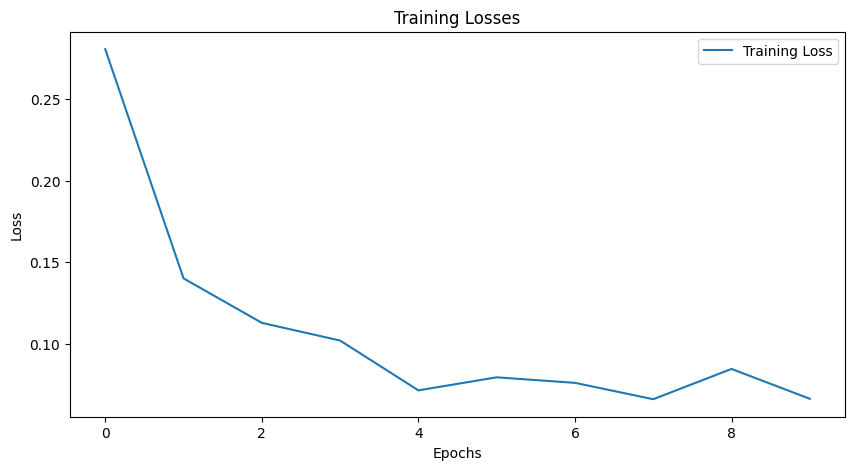

In [182]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

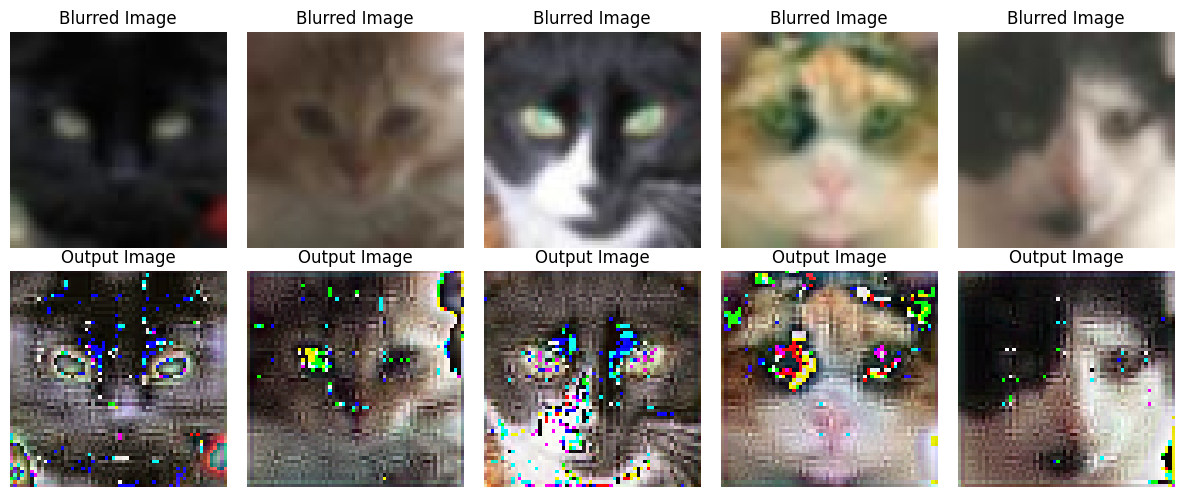

In [183]:
import random
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

def show_images(model, dataset, num_images=5):
    plt.figure(figsize=(12, num_images))

    for i in range(num_images):
        idx = i
        blurred_input_img = dataset[idx]
        input_img = blurred_input_img.unsqueeze(0).to(device)

        with torch.no_grad():
            output_img = model(input_img)

        output_img = output_img.squeeze(0).cpu()

        blurred_input_img_pil = transforms.functional.to_pil_image(blurred_input_img)
        output_img_pil = transforms.functional.to_pil_image(output_img)

        plt.subplot(2, num_images, i + 1)
        plt.imshow(blurred_input_img_pil)
        plt.title("Blurred Image")
        plt.axis('off')

        plt.subplot(2, num_images, i + num_images + 1)
        plt.imshow(output_img_pil)
        plt.title("Output Image")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_images(model, testDataset, num_images=5)